# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [26]:
# imports
from IPython.display import display, Math
from types import SimpleNamespace
import numpy as np
#import scipy as sp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
from inauguralproject import ExchangeEconomyClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

The set $\mathcal{C}$ requires finding pairs of goods $x_1^A$ and $x_2^A$ where the utility for both consumer A and B exceeds their initial endowment. Additionally, budget constraints prevent the consumers from consuming more than their initial endowment. Finally, 75 different allocations of each good should be tested for pairs of $x_1^A$ and $x_2^A$. Walras' law secures market clearance, thus we only need to find allocations of $x_1$ and $x_2$ for consumer A. The set $\mathcal{C}$ that fullfills these conditions is illustrated below. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


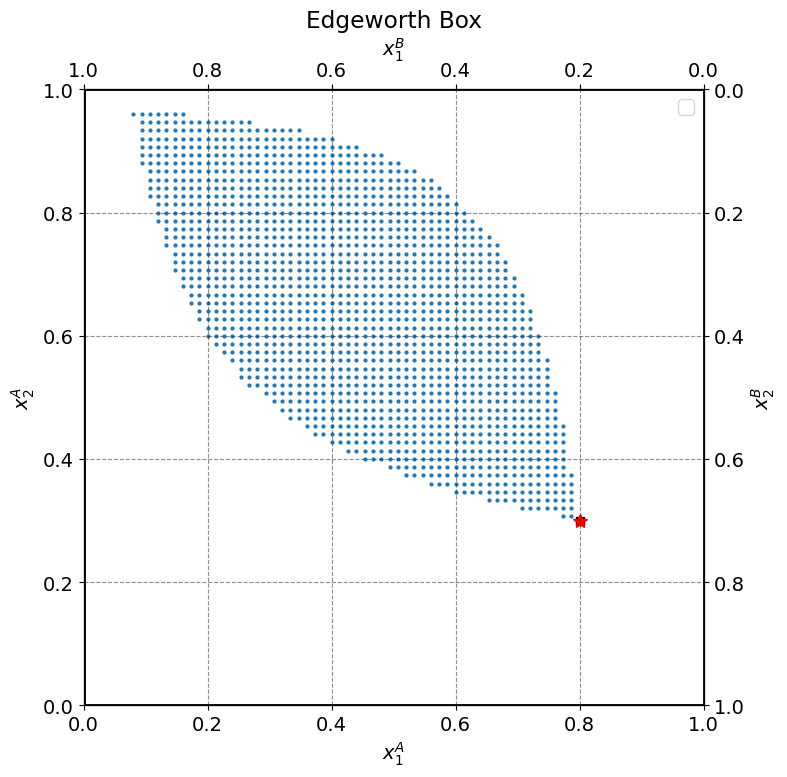

In [27]:
# creating an instance of the class
economy = ExchangeEconomyClass()
par = economy.par

# Compute initial utilities
initial_utility_A = economy.utility_A(par.w1A, par.w2A)
initial_utility_B = economy.utility_B(par.w1B, par.w2B)

initial_utility_A, initial_utility_B


# Assuming you have defined 'economy' and 'initial_utility_A', 'initial_utility_B' somewhere before

# Parameters
N = 75
x1A_values = np.linspace(0, 1, N+1)
x2A_values = np.linspace(0, 1, N+1)

# Create arrays to store Pareto efficient allocations
pareto_efficient_allocations = []

# Iterate over all possible combinations of x1A and x2A
for x1A in x1A_values:
    for x2A in x2A_values:
        # Ensure x1B and x2B are non-negative
        x1B = 1 - x1A
        x2B = 1 - x2A
        if x1B >= 0 and x2B >= 0:
            # Compute utilities for the current allocation
            utility_A = economy.utility_A(x1A, x2A)
            utility_B = economy.utility_B(x1B, x2B)

            # Check if both utilities are at least as high as the initial endowment utilities
            if utility_A >= initial_utility_A and utility_B >= initial_utility_B:
                pareto_efficient_allocations.append((x1A, x2A))

# Convert the list of allocations to a NumPy array for plotting
pareto_efficient_allocations = np.array(pareto_efficient_allocations)

# Plot the Edgeworth box with the Pareto efficient allocations
fig = plt.figure(frameon=False, figsize=(8, 8), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

# Plot Pareto efficient allocations
ax_A.plot(pareto_efficient_allocations[:, 0], pareto_efficient_allocations[:, 1], 'o', markersize=2, label='Pareto Efficient Allocations')

# Plot initial endowments
ax_A.plot(par.w1A, par.w2A, 'r*', markersize=10, label='Initial Endowment A')
# ax_A.plot(par.w1B, par.w2B, 'b*', markersize=10, label='Initial Endowment B')

# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')

# limits
ax_A.plot([0, 1], [0, 0], lw=2, color='black')
ax_A.plot([0, 1], [1, 1], lw=2, color='black')
ax_A.plot([0, 0], [0, 1], lw=2, color='black')
ax_A.plot([1, 1], [0, 1], lw=2, color='black')

ax_A.set_xlim([0, 1])
ax_A.set_ylim([0, 1])
  

# Design for B
temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()
ax_B.set_xlim([1, 0])
ax_B.set_ylim([1, 0])

# Show the plot
plt.title('Edgeworth Box')
plt.legend()
plt.grid(True)
John = plt.show()


def plt(name):
    plt.show(name)
    return nameofplot


The red star in the figure represents the initial endowment of the consumers, while the blue dots indicate Pareto-improving allocations. The figure demonstrates that consumer utility increases with a more equal distribution of the two goods in contrast to their initial endowment.

# Question 2

For  $p_1 \in \mathcal{P}_1$ the excess demand in the market clearing condition, s, is shown in the figure below.

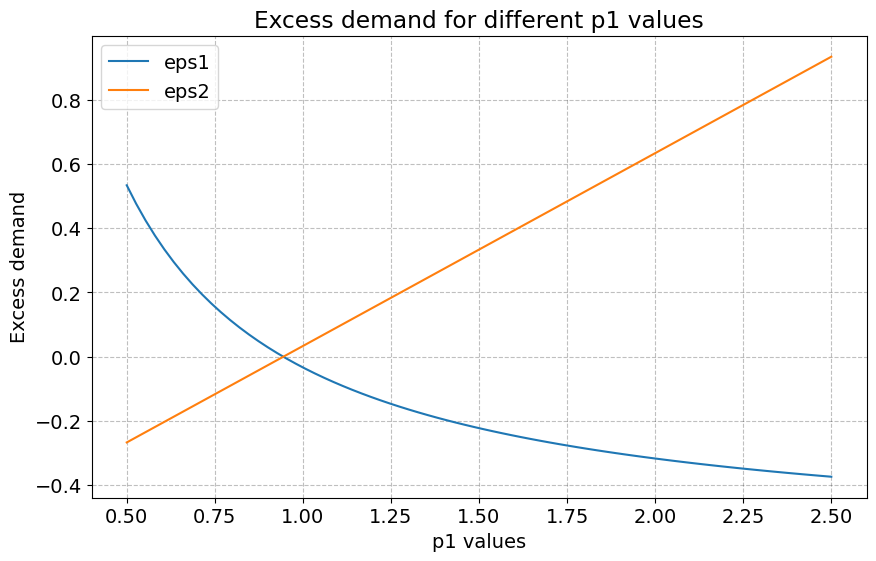

In [28]:
p1values = np.linspace(0.5, 2.5, N+1)
eps1_values = []
eps2_values = []

for p1 in p1values:
    eps1, eps2 = economy.check_market_clearing(p1)
    eps1_values.append(eps1)
    eps2_values.append(eps2)

#print(eps1_values, eps2_values)
# Plot the excess demand functions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(p1values, eps1_values, label='eps1')
plt.plot(p1values, eps2_values, label='eps2')
plt.xlabel('p1 values')
plt.ylabel('Excess demand')
plt.title('Excess demand for different p1 values')
plt.legend()
plt.show()

The figure illustrates that the excess demand equals zero at an approximate $p_1$ value of 0.9 (the exact market clearing price will be determined in the subsequent question). Furthermore, the orange line indicates that the excess demand for good 2 proportionally increases with the price of $p_1$. In contrast, the blue lines demonstrate that the excess demand for good 1 decreases as $p_1$ increases. 


# Question 3

The market clearing price is equal to:



In [29]:
def find_equilibrium(economy):
    # Define the excess demand function as a function of p1
    def excess_demand(p1):
        eps1, eps2 = economy.check_market_clearing(p1)
        return np.array([eps1, eps2])

    # Call the root finder
    result = minimize(lambda p1: np.sum(excess_demand(p1)**2), x0=1, method='Nelder-Mead', tol=1e-8)
    p1_star = result.x[0]
    return p1_star

print(find_equilibrium(economy))


0.9444444417953489


The market clearing price of 0.96 ensures that the excess demand for both goods equals zero, indicating full utilization of the initial endowment. This market clearing price matches the figure in Question 2.

# Question 4

__4a)__


In [31]:
# code
import numpy as np

utility_A_values = []
optimal_x1A = None
optimal_x2A = None

for p1 in p1values:
    x1A, x2A = economy.demand_A(p1)
    utility_A = economy.utility_A(x1A, x2A)
    utility_A_values.append(utility_A)
    if utility_A == max(utility_A_values):
        optimal_x1A = x1A
        optimal_x2A = x2A

max_utility_A = max(utility_A_values)

print("Optimal utility for A:", max_utility_A)
print("Optimal x1A value:", optimal_x1A)
print("Optimal x2A value:", optimal_x2A)


Optimal utility for A: 0.8966987730519458
Optimal x1A value: 0.30666666666666664
Optimal x2A value: 1.5333333333333334


4b) Allocation when any positive price can be chosen

In [44]:
def negative_utility_A(p1):
    # Get the demand for B given the price p1
    x1B, x2B = economy.demand_B(p1)
    
    # Calculate the remaining goods for A after B's consumption
    x1A_remaining = 1 - x1B
    x2A_remaining = 1 - x2B
    
    # The utility function for A expects positive consumption, if negative we return a large number
    if x1A_remaining < 0 or x2A_remaining < 0:
        return 1e6  # A large number to indicate a bad utility (not feasible)
    
    # Get the utility for A with the remaining goods
    utility_A = economy.utility_A(x1A_remaining, x2A_remaining)
    
    # We return the negative utility because we want to maximize the utility,
    # but the optimizer minimizes the function
    return -utility_A

# Find the price p1 that maximizes utility for A (minimizes the negative utility)
res = minimize_scalar(negative_utility_A, bounds=(0.00000, 15), method='bounded')

# The optimal price p1
optimal_p1 = res.x
optimal_p1, -res.fun  # We negate the fun value to get the actual utility

print(optimal_p1, -res.fun)


1.8993465837364023 0.6336208506936581


# Question 5

5a) Allocation if choice set is restricted to $\mathcal{C}$

In [41]:
# code


constant_utility_B = economy.utility_B(par.w1B, par.w2B)
# Define the constraint
cons = ({'type': 'eq', 'fun': lambda x:  economy.utility_B(x[0], x[1]) - constant_utility_B})

# Initial guess
x0 = np.array([0.5, 0.5])

# Define the objective function
def objective(x):
    return -economy.utility_A(x[0], x[1])  # We negate the utility to minimize

# Perform the optimization
res = minimize(objective, x0, constraints=cons, method='SLSQP')

# Print the result
print('Optimal allocation:', res.x)


initial_utility_B = economy.utility_B(par.w1B, par.w2B)

# Define the constraint for B's utility
def constraint_allocation(x):
    x1A, x2A = x
    x1B = 1 - x1A
    x2B = 1 - x2A
    return economy.utility_B(x1B, x2B) - initial_utility_B

# Define the optimization problem
def objective(x):
    x1A, x2A = x
    return -economy.utility_A(x1A, x2A)  # negative because minimize will be used

# Starting guess for A's allocation
x0 = [economy.par.w1A, economy.par.w2A]

# Define the constraints dictionary
cons = ({'type': 'ineq', 'fun': constraint_allocation})

# Run the optimizer
res = minimize(objective, x0, constraints=cons)

# Check if the optimization was successful
if res.success:
    allocated_x1A, allocated_x2A = res.x
    utility_A = -res.fun
    print(f"Allocation for A: x1 = {allocated_x1A}, x2 = {allocated_x2A}, with utility = {utility_A}")
else:
    print("Optimization was not successful.")



Optimal allocation: [1.27229393e-06 1.51152312e+10]
Optimization was not successful.


5b) Allocation with no restrictions

In [ ]:
# code

# Question 6


6a) Allocation with social planner

In [42]:
# code


# Objective function for the social planner
def objective_function(x):
    x1A, x2A, x1B, x2B = x
    return -(economy.utility_A(x1A, x2A) + economy.utility_B(x1B, x2B))

# Constraints for the optimization problem
def constraint1(x):
    return x[0] + x[2] - economy.par.w1A - economy.par.w1B

def constraint2(x):
    return x[1] + x[3] - economy.par.w2A - economy.par.w2B

# Initial guess for consumption allocations
x0 = [0.5, 0.5, 0.5, 0.5]  

# Bounds for consumption allocations (non-negative consumption)
bounds = [(0, None)] * 4  # Bounds for each variable

# Defining the constraints
cons = [{'type': 'eq', 'fun': constraint1}, {'type': 'eq', 'fun': constraint2}]

# Solving the optimization problem
result = minimize(objective_function, x0, bounds=bounds, constraints=cons)

# Extracting the optimal allocation
optimal_allocation = result.x

print("Optimal allocation:")
print("x1A:", optimal_allocation[0])
print("x2A:", optimal_allocation[1])
print("x1B:", optimal_allocation[2])
print("x2B:", optimal_allocation[3])

Optimal allocation:
x1A: 0.3333333432674408
x2A: 0.6666666641831397
x1B: 0.6666666567325592
x2B: 0.3333333358168603


6b) Illustration and comparison with previous questions

In [ ]:
# code

# Question 7 + 8

Set, $\mathcal{W}$, drawn with 50 elements

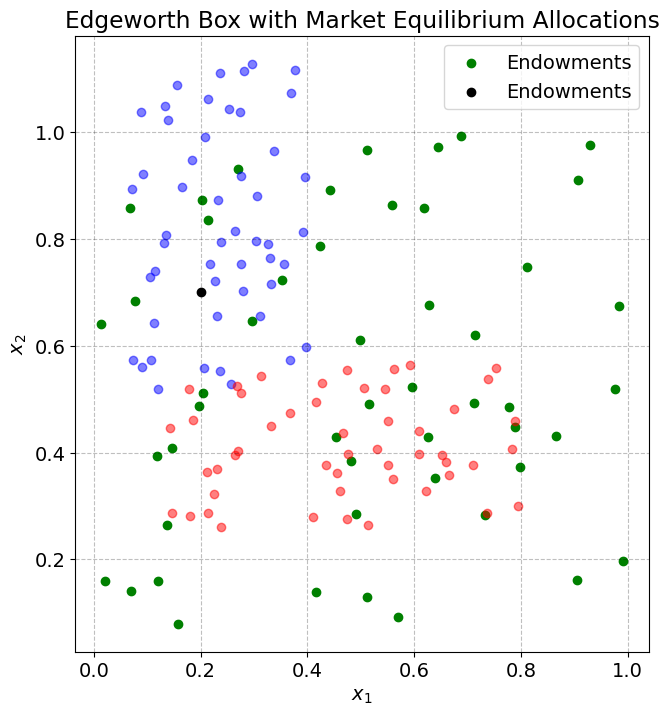

In [43]:
# code
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Step 1: Generate set W
num_elements = 50
w1A_values = np.random.uniform(0, 1, num_elements)
w2A_values = np.random.uniform(0, 1, num_elements)

# Create a scatter plot for the Edgeworth box
fig = plt.figure(frameon=False, figsize=(8, 8), dpi=100)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Edgeworth Box with Market Equilibrium Allocations')

# Plot the endowments
plt.scatter(w1A_values, w2A_values, color='green', label='Endowments')
plt.scatter(economy.par.w1B, economy.par.w2B, color='black', label='Endowments')

# Iterate through each endowment and plot the corresponding allocations
for economy.par.w1A, economy.par.w2A in zip(w1A_values, w2A_values):
    # Define objective function to minimize excess demand
    def objective_function(p):
        p1, p2 = p
        x1A = economy.par.alpha * (p1 * economy.par.w1A + p2 * economy.par.w2A) / p1
        x2A = (1 - economy.par.alpha) * (p1 * economy.par.w1B + p2 * economy.par.w2B) / p2
        x1B = economy.par.beta * (p1 * economy.par.w1A + p2 * economy.par.w2A) / p1
        x2B = (1 - economy.par.beta) * (p1 * economy.par.w1B + p2 * economy.par.w2B) / p2
        excess1 = x1A + x1B - economy.par.w1A - economy.par.w1B
        excess2 = x2A + x2B - economy.par.w2A - economy.par.w2B
        return excess1**2 + excess2**2

    # Initial guess for prices
    p0 = [1.0, 1.0]

    # Minimize the objective function to find market clearing prices
    result = minimize(objective_function, p0)

    # Extract the market clearing prices
    p1, p2 = result.x

    # Calculate optimal allocations for individuals A and B
    x1A = economy.par.alpha * (p1 * economy.par.w1A + p2 * economy.par.w2A) / p1
    x2A = (1 - economy.par.alpha) * (p1 * economy.par.w1B + p2 * economy.par.w2B) / p2
    x1B = economy.par.beta * (p1 * economy.par.w1A + p2 * economy.par.w2A) / p1
    x2B = (1 - economy.par.beta) * (p1 * economy.par.w1B + p2 * economy.par.w2B) / p2

    # Plot the allocation in the Edgeworth box
    plt.scatter(x1A, x2A, color='blue', alpha=0.5)
    plt.scatter(x1B, x2B, color='red', alpha=0.5)

plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

